In [62]:
def sdqn_tester(env, train_st_fc, 
               load_data, generation_data, feature, 
               summer_TOU, winter_TOU, 
               T ,Tf, start_day, battery_max,
               path):
    
    q = Qnet(feature)
    q.load_state_dict(torch.load(path))
    
    # test 시작
    train_st = train_st_fc()

    state = env.initialize_state(start_day)

    battery, action = 0, 0

    cost_history, battery_history,action_history, violation_history = [],[],[],[]

    for n_epi in range(days):
        TOU = winter_TOU
        cum_cost, day_action, day_battery, day_vio = 0, [] , [], []

        for time in range(0, 24):
            battery = state[0] - state[50] + state[51+Tf]
            if battery > battery_max: battery = battery_max
            action = train_st.select_action(q, torch.from_numpy(state).float(), battery, battery_max)

            day_action.append(action)
            day_battery.append(state[0])

            new_state, reward, violation = env.step(n_epi=n_epi, time=time, battery=battery, charge=action, 
                                            day_charge=day_action, TOU=TOU)
            cum_cost = cum_cost + reward

            state = new_state
            
            day_vio.append(violation)

        cost_history.append(cum_cost)
        action_history.append(day_action)
        battery_history.append(day_battery)
        violation_history.append(day_vio)
    return cost_history, action_history, battery_history, violation_history

In [78]:
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

from codes.utills import load_and_generte
from codes.ploting import charge_graph
from codes.model import Qnet
from codes.env import Environment_minc
from codes.strategy import GreedyStrategy
from glob import glob

f_load = pd.read_csv('1년치 소비데이터.csv')

f_generation = pd.read_csv("태양광데이터1.csv",encoding='cp949')

# test 시에는 30~60일로 (train은 0~30)
start_day = 30 # 인덱스
end_day = 60 #인덱스
days = end_day-start_day
pos_name = '영암에프원태양광b'

load_data, generation_data = load_and_generte(f_load, f_generation, pos_name, start_day, end_day)

T = np.identity(n=24, dtype=np.uint8)

winter_TOU = [5,5,5, 5,5,5, 5,15,15, 15,25,10, 10,10,10, 10,10,15, 15,5,5, 5,5,5]  # 겨울
summer_TOU = [5,5,5, 5,5,5, 5,10,10 ,10,10,15, 15,15,15, 15,15,10, 10,5,5,5,5,5]  #여름

Tf= 0
feature = 52 + 2*Tf
battery_max = 40
pD = 30

# 기학습된 모델 load
paths = [r'weight/T/q_ESDQN_EGreedyLinearStrategy_32_2.pth']

# 환경 정의
env = Environment_minc(
                    feature,
                    load_data, 
                    generation_data,
                    days, 
                    T,
                    Tf, 
                    pD,
                    summer_TOU, winter_TOU,
                    battery_max
                    )
config = {
    "env":env, 
    "train_st_fc":GreedyStrategy, 
    "load_data":load_data, 
    "generation_data":generation_data,
    "feature":feature, 
    "summer_TOU":summer_TOU, 
    "winter_TOU":winter_TOU, 
    "T":T,
    "Tf":Tf, 
    "start_day":start_day, 
    "battery_max":battery_max,
}
cost_dict, action_dict, battery_dict, violation_dict = {}, {}, {}, {}
for path in paths:
    cfg = config.copy()
    cfg['path'] = path
    cost_dict[path],action_dict[path], battery_dict[path], violation_dict[path] = sdqn_tester(**cfg)

C:\Users\user1229\hong\safe_learning_ESS\codes\env.py:161: RuntimeWarning: divide by zero encountered in log
  sd = np.log(day_load * TOU)


In [90]:
# 필요할때마다 사는 경우?
greedy_cost = 0
for i in range(days):
    if i < 90 or i >= 273:TOU = winter_TOU
    else: TOU = winter_TOU
    for j in range(24):
        gap = load_data[i][j] - generation_data[i][j]
        if gap < 0:
            gap = 0
        greedy_cost = greedy_cost + TOU[j] * gap
    greedy_cost = greedy_cost + 30*max(load_data[i])
print(greedy_cost)

29890


In [91]:
action_history = action_dict[paths[0]]
temp_cost = 0
for i in range(end_day-start_day):
    TOU = winter_TOU
    for j in range(24):
        temp_cost = temp_cost + action_history[i][j] * TOU[j]
    temp_cost = temp_cost + 30*max(action_history[i])
print(temp_cost)

20555


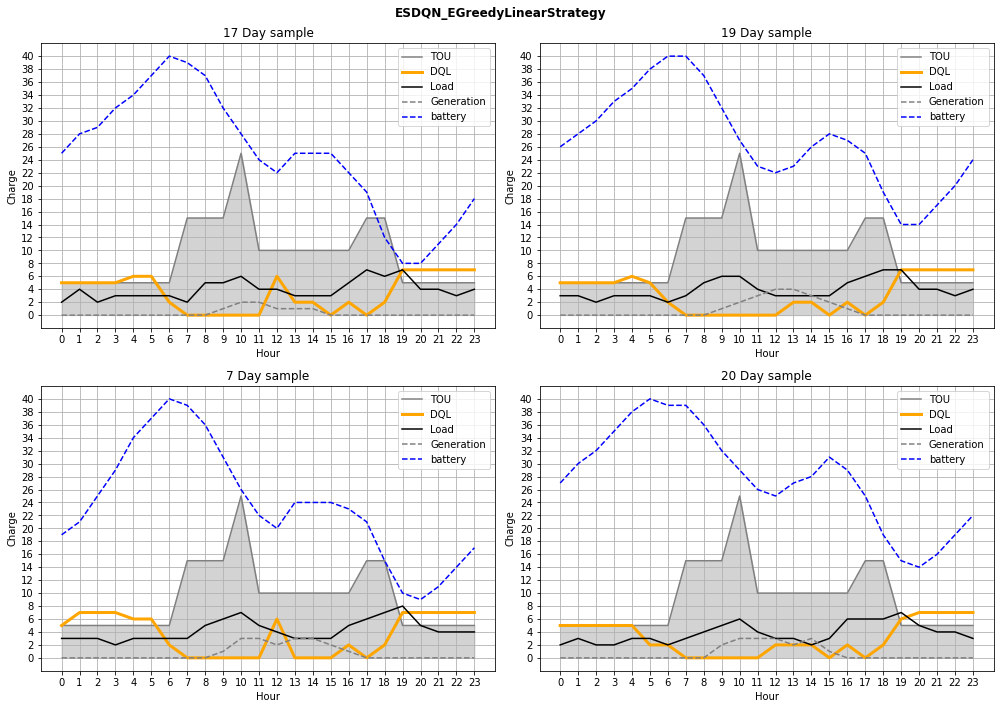

In [98]:
path = paths[0]
charge_graph(load_data, generation_data, winter_TOU, action_dict[path], battery_dict[path], path)

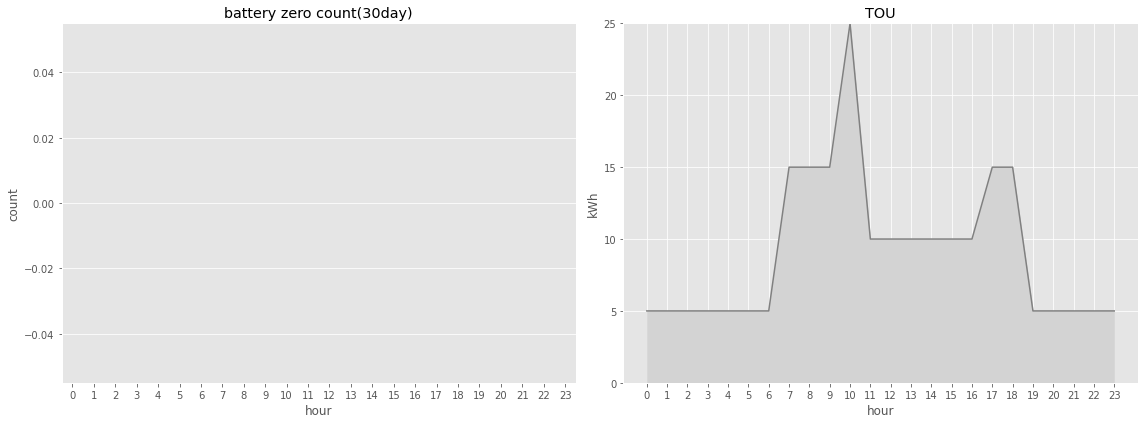

In [82]:
import seaborn as sns
import pandas as pd

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 2, figsize=(8*2,6))
    hour_count = {str(hour):num for hour, num in zip(range(24), np.sum(np.array(violation_dict[path]), axis=0))}
    data = pd.DataFrame(hour_count, index=[0])
    sns.barplot(data=data, ax=ax[0])
    
    ax[1].plot(range(24), TOU, label='TOU', color='gray')
    ax[1].fill_between(range(24), TOU, color='lightgray')
    ax[1].set_ylim([0, 25])
    ax[1].set_xticks(range(24))
    
    ax[0].set(xlabel="hour", ylabel='count', title=f"battery zero count({days}day)")
    ax[1].set(xlabel='hour', ylabel="kWh", title='TOU')
    fig.tight_layout()
    plt.show()

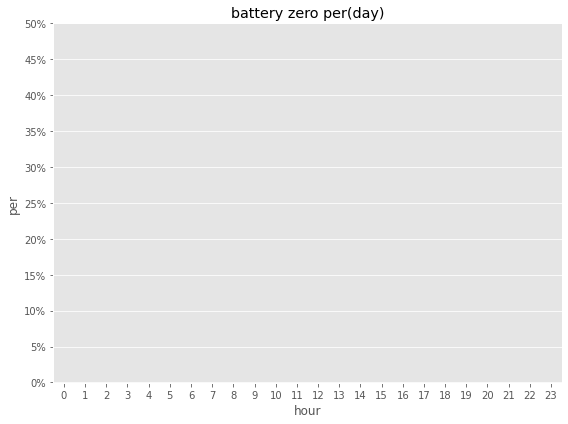

In [83]:
import seaborn as sns
import pandas as pd

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, figsize=(8,6))
    hour_count = {str(hour):num for hour, num in zip(range(24), np.sum(np.array(violation_dict[path]), axis=0) / days * 100)}
    data = pd.DataFrame(hour_count, index=[0])
    sns.barplot(data=data, ax=ax)
    ax.set_yticks(range(0,51,5), [str(per) + '%' for per in range(0,51, 5)])
     
    ax.set(xlabel="hour", ylabel='per', title=f"battery zero per(day)")
    fig.tight_layout()
    plt.show()

In [84]:
# 하루 평균 방전 횟수

print(f"하루 평균 방전 발생 : {np.sum(np.array(violation_dict[path])) / days * 100}%")

하루 평균 방전 발생 : 0.0%
